In [ ]:
##Load in RADAR data for Kalman Filter updates


In [1]:
import numpy as np
from matplotlib import pyplot as plt

fname = './obj_pose-laser-radar-synthetic-input.txt'
LIDAR = []
RADAR = []
data = open(fname, "r")

for line in data:
   LIDAR.append(line.split()) if line[0] == 'L' else RADAR.append(line.split())


RADAR = np.squeeze(np.array([RADAR]))
radar_rho = RADAR[:,1].astype(float).tolist()
radar_phi = RADAR[:,2].astype(float).tolist()
radar_rhodot = RADAR[:,3].astype(float).tolist()
radar_ts = RADAR[:,4].astype(int).tolist()
radar_truth_x = RADAR[:,5].astype(float).tolist()
radar_truth_y = RADAR[:,6].astype(float).tolist()
radar_truth_xdot = RADAR[:,7].astype(float).tolist()
radar_truth_ydot = RADAR[:,8].astype(float).tolist()


def update_F_matrix(dt):
    return np.array([[1,0,dt,0], [0,1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])

def update_Q_matrix(dt, noise_ax, noise_ay):
    
    return np.array([[np.power(dt,4)/4*noise_ax, 0, np.power(dt,3)/2*noise_ax, 0],
         [0, np.power(dt,4)/4*noise_ay, 0, np.power(dt,3)/2*noise_ay],
         [np.power(dt,3)/2*noise_ax, 0, np.power(dt,2)*noise_ax, 0],
         [0, np.power(dt,3)/2*noise_ay, 0, np.power(dt,2)*noise_ay]])

    

##step 2/7
def initial_process_cov_matrix():
    global P
        
    #initial process covariance matrix
    ##do this once

    P = np.array([[1,0,0,0], [0,1,0,0], [0,0,1000,0],[0,0,0,1000]])
 
    if verbose: print("Initial Process Covariance Matrix:", P)

##step 1/7; 
def update_prediction():
    global x,u,A,B
    #print("x before update:", x)
    x = np.dot(A,x) + np.dot(B,u)

    if verbose: print("x after update: ", x)

def update_predicted_process_cov_matrix():
    global A, P, Q
    #update the Process Covariance Matrix
    #Q = 0.  ##reflects the error in calculating process cov matrix (not sure what)
    P = np.dot(np.dot(A, P), A.T) + Q
    #P[0,1] = 0
    #P[1,0] = 0
    if verbose: print("Predicted Process Covariance Matrix: ", P)

#steps 1-3 are the same for linear KF and EKF
#change the H * x term to h(x)

        
def calculate_H_Jacobian():
    
    #use predicted x to update the jacobian
    px, py, vx, vy = x[0], x[1], x[2], x[3]
    
    c1 = np.power(px,2)+np.power(py,2)
    c2 = np.sqrt(c1)
    c3 = c1*c2

    Hj = np.zeros([3,4])
    Hj[0,0] = px/c2
    Hj[0,1] = py/c2
    
    Hj[1,0] = -py/c1
    Hj[1,1] = px/c1
    
    Hj[2,0] = py*(vx*py - vy*px)/c3
    Hj[2,1] = px*(vy*px - vx*py)/c3
    Hj[2,2] = px/c2
    Hj[2,3] = py/c2
    
    return Hj

In [2]:
#step 4/7 calculate the kalman gain
def radar_calculate_Kalman_gain():
    global R_radar, P, Hj, K
    
    S = R_radar + np.dot(Hj, np.dot(P, Hj.T))
    K = np.dot(np.dot(P, Hj.T), np.linalg.inv(S))
  
    if verbose:
        print("RADAR S:", S)
        print("RADAR: Kalman Gain Matrix: ", K)    

 #step 5/7 import a measurment
def radar_import_new_observation(m):
    global z
    #Step 5/7
    ##import the new observation
    #Observed state Yk = CYkm + Zk
    C = np.eye(3)
    measurement = np.array(m)
    z = np.dot(C, measurement)
    
    if verbose: print("RADAR: observed: ", z)

#step 6/7 update the current state

def radar_update_current_state():
    global z, Hj, x
    #step 6/7
    px, py, vx,vy = x[0], x[1], x[2], x[3]
    rho_pred = np.sqrt(px*px + py*py)
    phi_pred = np.arctan2(py, px)
    rhodot_pred = (px*vx + py*vy)/rho_pred

 
    Y = z - np.array([rho_pred, phi_pred, rhodot_pred])
    
    ##check Y[1], the delta for phi - phi_pred;  This value must be <> -pi:pi
    ##substract 2pi until Y[1] is in range or else the states can have
    ##very large velocity values.  
    
    while np.abs(Y[1]) > np.pi:
        if verbose: print("adjusting Y[1]")
        if Y[1] < 0:
            Y[1] += 2*np.pi
        else:
            Y[1] -= 2*np.pi
 
    x = x + np.dot(K, Y)
    #print("X after: ", x)
    if verbose:
        print("px:, py: vx: vy:", px, py, vx, vy)
        print("rho_pred, phi_pred, rdot_pred:", rho_pred, phi_pred, rhodot_pred) 
        print("RADAR: adjusted x:", x)
        print("RADAR: Y: ", Y)
        
#step 7/7 update the process covariance matrix
def radar_update_process_cov_matrix():
    global K, Hj, R_radar, P

    I = np.eye(n)
    P = np.dot(np.dot(I - np.dot(K, Hj), P), 
                (I - np.dot(K, Hj)).T) + np.dot(np.dot(K, R_radar), K.T)   

    if verbose: print("RADAR: Updated Process Covariance Matrix: ", P)
        

In [3]:
def cartesian_to_polar(cartesian_x_):
    THRESH = 0.0001;
    cartesian_x = cartesian_x_.flatten()
    px, py, vx, vy = cartesian_x[0], cartesian_x[1], cartesian_x[2], cartesian_x[3]
    rho = np.sqrt(px**2 + py**2)
    phi = np.arctan2(py, px)
    drho = 0
    if rho > THRESH: drho = (px*vx + py*vy) / rho
    
    return np.array([rho, phi, drho])

#convert polar radar measurement data to cartesian
def polar_to_cartesian(rho, phi, rhodot):
    
    px = rho * np.cos(phi)
    py = rho * np.sin(phi)
    vx = rhodot * np.cos(phi)
    vy = rhodot * np.sin(phi)
    return np.array([px, py, vx, vy])
 
 

In [24]:
import numpy as np
from matplotlib import pyplot as plt


verbose = False

dt = .1
A = update_F_matrix(dt)

B = np.zeros([4])
u = 0 #2 m/s**2

n = A.shape[1]
noise_ax, noise_ay = 5, 5

Q = update_Q_matrix(dt, noise_ax, noise_ay)
print("Q: ", Q)

R_radar = np.zeros([3,3])
R_radar[0,0] = .09
R_radar[1,1] = .0009
R_radar[2,2] = .09


current_timestamp = radar_ts.pop(0)

#x = np.array([radar_x, radar_y, radar_xdot, radar_ydot]) 
x = np.array([radar_truth_x.pop(0), radar_truth_y.pop(0), 0, 0]) 
print("RADAR initial timestamp: ", current_timestamp)
print("RADAR initial x: ", x)
                                 
##initialize prediction
x_predict, y_predict = [], []
x_filtered, y_filtered, xdot_filtered, ydot_filtered = [], [], [], []
x_truth, y_truth, xdot_truth, ydot_truth = [], [], [], []
x_measured, y_measured = [], []

initial_process_cov_matrix()
print("initial timestamp: ", current_timestamp)
n_observations = len(radar_rho)

for obs in range(n_observations):
  rho, phi, rhodot = radar_rho[obs], radar_phi[obs], radar_rhodot[obs]
  ts = radar_ts[obs]
  x_truth, y_truth = radar_truth_x[obs], radar_truth_y[obs]
  xdot_truth, ydot_truth = radar_truth_xdot[obs], radar_truth_ydot[obs] 
    
  previous_timestamp = current_timestamp

  #update the A and Q matrices
 
  current_timestamp = ts
  dt =  (current_timestamp - previous_timestamp)/1000000.

  print("dt: ", dt, current_timestamp, previous_timestamp)
  A = update_F_matrix(dt)
  Q = update_Q_matrix(dt, noise_ax, noise_ay) 
  
  update_prediction()
 
  update_predicted_process_cov_matrix()
      
  x_predict.append(x[0])
  y_predict.append(x[1])
        
  #use new x data to update the Jacobian 
  Hj = calculate_H_Jacobian()
        
  #compute the Kalman gain
  radar_calculate_Kalman_gain()  #now in polar

  radar_import_new_observation ([rho, phi, rhodot])
  radar_update_current_state()
        
  radar_update_process_cov_matrix()
    
  #x = np.array([cartesian[0], cartesian[1], cartesian[2], cartesian[3]])  
  x_filtered.append(x[0])
  y_filtered.append(x[1])
  xdot_filtered.append(x[2])
  ydot_filtered.append(x[3])     
  #input("Press Enter to continue...")

     #print("updated state x: ", x)

    

Q:  [[0.000125 0.       0.0025   0.      ]
 [0.       0.000125 0.       0.0025  ]
 [0.0025   0.       0.05     0.      ]
 [0.       0.0025   0.       0.05    ]]
RADAR initial timestamp:  1477010443350000
RADAR initial x:  [1.369551  0.6026572 0.        0.       ]
initial timestamp:  1477010443350000
dt:  0.1 1477010443450000 1477010443350000
x:, y: vx: vy: 1.369551 0.6026572 0.0 0.0
rho_pred, phi_pred, rdot_pred: 1.4962839444145752 0.41454037267274707 0.0
Y:  [-0.59762554  0.20313323  1.798602  ]
dt:  0.1 1477010443550000 1477010443450000
x:, y: vx: vy: 0.8116009199691114 0.990978361558098 0.5275277811626746 3.2504477599255575
rho_pred, phi_pred, rdot_pred: 1.2809114592238922 0.8845831694943945 2.84895993527391
Y:  [-0.37033716 -0.27404627 -1.38663394]
dt:  0.1 1477010443650000 1477010443550000
x:, y: vx: vy: 1.232415067060775 0.7926183899751076 1.9905503273544063 0.5810358498133783
rho_pred, phi_pred, rdot_pred: 1.46529546837665 0.5715392996582428 1.9884889961471324
Y:  [-0.02371047 -

dt:  0.1 1477010448750000 1477010448650000
x:, y: vx: vy: 8.8262149190403 5.569813749880708 0.02157789674953925 1.5937770910575375
rho_pred, phi_pred, rdot_pred: 10.436709012205416 0.5629405501575072 0.8688076576270627
Y:  [ 0.04426099 -0.04359085 -0.17407756]
dt:  0.1 1477010448850000 1477010448750000
x:, y: vx: vy: 8.906502301765931 5.577481143202132 0.10420271902512067 1.3220324283067098
rho_pred, phi_pred, rdot_pred: 10.508762018151195 0.5594802727927293 0.7899781803119011
Y:  [-0.03979202  0.02477163 -0.51940598]
dt:  0.1 1477010448950000 1477010448850000
x:, y: vx: vy: 8.814496522177418 5.753095304755535 -0.2037119260703385 1.2955272303684569
rho_pred, phi_pred, rdot_pred: 10.52584697423813 0.5782608762635355 0.5375029274308976
Y:  [-0.59759897  0.00309322  0.15425967]
dt:  0.1 1477010449050000 1477010448950000
x:, y: vx: vy: 8.751499225149287 5.872446475867442 -0.18222431163803252 1.3378614160074949
rho_pred, phi_pred, rdot_pred: 10.53918243032715 0.591011615806169 0.59414320578

dt:  0.1 1477010452250000 1477010452150000
x:, y: vx: vy: 3.7492343564298114 8.406470811030031 -2.1855908858857753 -0.5984741099410731
rho_pred, phi_pred, rdot_pred: 9.204646096191508 1.1512789006134494 -1.436812174702916
Y:  [-0.0721581   0.0552971  -0.71386983]
dt:  0.1 1477010452350000 1477010452250000
x:, y: vx: vy: 3.320965562611709 8.341286714359432 -2.615609480931798 -0.8338932979349527
rho_pred, phi_pred, rdot_pred: 8.97807754027565 1.1918979781885033 -1.7422540659181172
Y:  [ 0.02088446 -0.02917998  0.39289407]
dt:  0.1 1477010452450000 1477010452350000
x:, y: vx: vy: 3.164106036168624 8.267006912017642 -2.4012957017997913 -0.6892353873809638
rho_pred, phi_pred, rdot_pred: 8.85183428965241 1.2052580940825155 -1.5020466381435358
Y:  [ 0.01911371 -0.02537709 -0.07604636]
dt:  0.1 1477010452550000 1477010452450000
x:, y: vx: vy: 3.0105413968739203 8.159362300522393 -2.2625135163383248 -0.7697084965557683
rho_pred, phi_pred, rdot_pred: 8.697042753343096 1.2173246804499602 -1.50530

Y:  [ 0.1939122  -0.03329139 -0.60368672]
dt:  0.1 1477010456550000 1477010456450000
x:, y: vx: vy: -1.0418453775686145 0.8181390926739252 -0.5497878762859214 -2.0789430241634315
rho_pred, phi_pred, rdot_pred: 1.3246861385710966 2.475892729642297 -0.8515757575412716
Y:  [0.02315386 0.06067927 0.57697326]
dt:  0.1 1477010456650000 1477010456550000
x:, y: vx: vy: -1.1921853164634904 0.5733852743353709 -0.9274950575343698 -2.16127650063072
rho_pred, phi_pred, rdot_pred: 1.3229045701091977 2.6932983058894306 -0.1009128954273553
Y:  [ 0.49809743 -0.07723831  0.15860512]
dt:  0.1 1477010456750000 1477010456650000
x:, y: vx: vy: -1.3354904139028552 0.48527802548003623 -0.9889836098978405 -1.857517762474497
rho_pred, phi_pred, rdot_pred: 1.4209255461283754 2.7930563476397423 0.29513550488309664
Y:  [ 0.18169745  0.02527865 -0.33506755]
dt:  0.1 1477010456850000 1477010456750000
x:, y: vx: vy: -1.4160412680257362 0.2613833853964762 -0.8576294648971503 -2.0142174901433507
rho_pred, phi_pred, rdo

x:, y: vx: vy: -8.874101795733015 1.77099246379376 1.195769369556256 1.8995161612374907
rho_pred, phi_pred, rdot_pred: 9.04909371085559 2.9446118933252787 -0.8008923915288331
Y:  [ 0.14853329 -0.00649389  0.07947729]
dt:  0.1 1477010464850000 1477010464750000
x:, y: vx: vy: -8.772203377979794 1.9916603608891048 1.158900569617285 1.9547859049663723
rho_pred, phi_pred, rdot_pred: 8.995457914846638 2.9183352673116802 -0.6973343602931125
Y:  [ 0.04348609  0.03188473 -0.22483424]
dt:  0.1 1477010464950000 1477010464850000
x:, y: vx: vy: -8.664092465898376 2.0635642543258927 1.2075024680149204 1.7304900848722806
rho_pred, phi_pred, rdot_pred: 8.906446861087119 2.907774643168529 -0.7737019780784773
Y:  [ 0.11242114 -0.00125764 -0.29212002]
dt:  0.1 1477010465050000 1477010464950000
x:, y: vx: vy: -8.522347402314038 2.229748657737875 1.3445466874422174 1.6903574797174459
rho_pred, phi_pred, rdot_pred: 8.809210198559954 2.8856932616383535 -0.872907045488936
Y:  [-0.3793852   0.02242574 -0.26696

IndexError: list index out of range

In [ ]:
np.power(2,2) + np.power(-1.7,2)
np.arctan2(8.12,2)

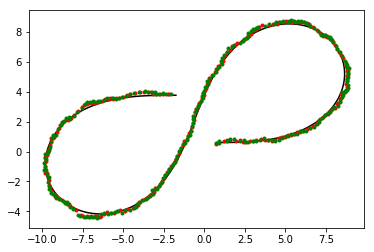

In [10]:
#plt.plot(x_predict, y_predict)
#plt.show()
plt.plot(radar_truth_x, radar_truth_y,'k')
#plt.plot(x_measured, y_measured, 'r.')
plt.plot(x_filtered, y_filtered, 'r.')
plt.plot(x_predict, y_predict, 'g.')
plt.show()

In [ ]:
print(np.shape(xdot_filtered))
print(np.shape(ydot_filtered))

print(np.shape(xdot_truth))

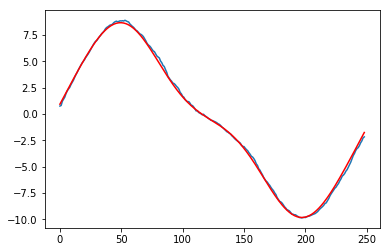

In [18]:
plt.plot(np.array(x_filtered))
plt.plot(np.array(radar_truth_x),'r')

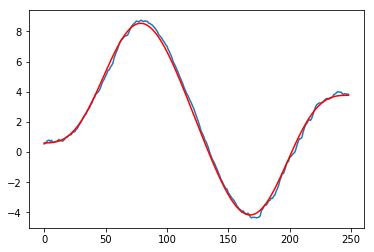

In [19]:
plt.plot(np.array(y_filtered))
plt.plot(np.array(radar_truth_y),'r')               

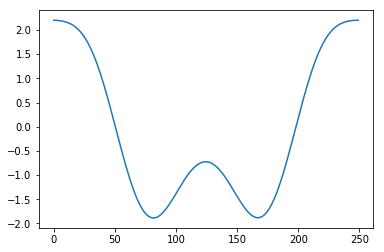

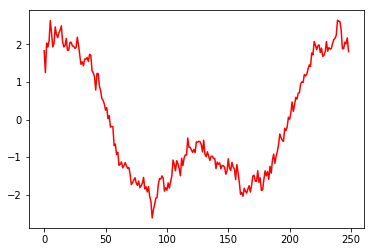

In [11]:
plt.plot(radar_truth_xdot)

plt.show()
plt.plot(xdot_filtered,'r')
#plt.plot(ydot_truth,'r')
plt.show()

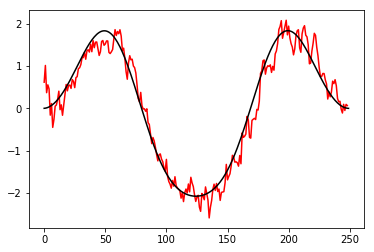

In [15]:

plt.plot(ydot_filtered,'r')
plt.plot(radar_truth_ydot,'k')
plt.show()

In [16]:
def calculate_RMSE(predicted_values,truth_values):
    residuals = np.array(predicted_values) - np.array(truth_values)
    sum_residuals = np.sum(residuals*residuals)
    mean_error = sum_residuals/len(residuals)
    return np.sqrt(mean_error)

In [17]:
x_rmse = calculate_RMSE(x_filtered, radar_truth_x)
y_rmse = calculate_RMSE(y_filtered, radar_truth_y)

print("x_rmse, y_rmse: ", x_rmse, y_rmse)


x_rmse, y_rmse:  0.18943255463786218 0.2055055629657851


In [ ]:
#range of phi -pi:pi
x, y = [],[]
xdot, ydot = [], []

phi = np.arange(-np.pi,np.pi, .1)
rhodot = np.arange(-2,2,-1)
print(len(phi), len(rhodot))

for sample in phi:
    #print(sample)
    carts = polar_to_cartesian(1,sample,1)
    x.append(carts[0])
    y.append(carts[1])
    xdot.append(carts[2])
    ydot.append(carts[3])

#print(x)
#print(y)
plt.plot(x,y,'r.')
plt.show()

plt.plot(xdot)
plt.plot(ydot, 'r')
plt.show()



